# Lab 3: sport vs politics

Our goal is to build a system that:
1. everyday collects a large set of random tweets and groups them in tweets about politics
2. for each of the two groups, shows the main topics of discussion

Unfortunately, it is very difficult to collect a proper number of tweets from X using its API. To build a reasonable dataset, we rely on existing datasets:
- tweets about 2022 FIFA World Cup (sport tweets)
- tweets about Joe Biden (politics tweets)
We need a third category of tweets, random tweets that do not belong to these two categories. To generate them we will use sentences in some free and well known books.

Please note that we are using biased data that will lead to a biased system: sport is not just football and politics does not include only Joe Biden. Since we are aware of it, we can start this challenge.


## Preparing the data

We will use:
- `pandas` for organizing the data;
- `nltk` and `langdetect` to process text;
- `scikit-learn` to train ML models;
- `wordcloud` for fancy visualization;

In [6]:
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install langdetect
!pip install wordcloud

In [7]:
import pandas as pd
import random, string, nltk, re
from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.book import *
from nltk.tokenize import sent_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('genesis')
nltk.download('inaugural')
nltk.download('nps_chat')
nltk.download('webtext')
nltk.download('treebank')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package inaugural to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package nps_chat to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package treebank is already up

True

We start by loading 5000 tweets from each of csv files.

In [8]:
sports_tweets = pd.read_csv("./lab3_data/fifa_world_cup_2022_tweets.csv", nrows=5000, usecols=["Tweet"], low_memory=False)
politics_tweets = pd.read_csv("./lab3_data/hashtag_joebiden.csv", nrows=5000, usecols=["tweet"], low_memory=False)

In [9]:
sports_tweets.columns=["tweet"]
sports_tweets

,tweet
0,What are we drinking today @TucanTribe \n@MadB...
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,Worth reading while watching #WorldCup2022 htt...
3,Golden Maknae shinning bright\n\nhttps://t.co/...
4,"If the BBC cares so much about human rights, h..."
...,...
4995,Looks like the offside controversy isn't going...
4996,Another goal by the same captain lol 🤣😂😂🤣😂🤣🇪🇨🇪...
4997,Goal again Valencia! Ecuador! Should have been...
4998,E. Valencia doubles the lead for #ECU \nWonder...


In [10]:
politics_tweets

,tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...
3,@chrislongview Watching and setting dvr. Let’s...
4,#censorship #HunterBiden #Biden #BidenEmails #...
...,...
4995,@BreitbartNews @realDonaldTrump @CIA @FBI * EX...
4996,Trump 2020 never ever let you down yard sign\n...
4997,@faznet #FAZ verharmlost einen polit. Skandal ...
4998,@MaajidNawaz @TuckerCarlson Shady deals are sh...


In [11]:
sports_tweets

,tweet
0,What are we drinking today @TucanTribe \n@MadB...
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,Worth reading while watching #WorldCup2022 htt...
3,Golden Maknae shinning bright\n\nhttps://t.co/...
4,"If the BBC cares so much about human rights, h..."
...,...
4995,Looks like the offside controversy isn't going...
4996,Another goal by the same captain lol 🤣😂😂🤣😂🤣🇪🇨🇪...
4997,Goal again Valencia! Ecuador! Should have been...
4998,E. Valencia doubles the lead for #ECU \nWonder...


The first step of the data cleaning is dropping NAs.

In [12]:
for df in [politics_tweets, sports_tweets]:
    df.dropna(inplace=True)

Define a function to determine if a tweet is written in english or not. We would like to consider only tweets in english.

In [13]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

Use such function to drop the non-english tweets. It take one or two minutes. In the meantime drink a coffee or just smoke a cigarette.

In [14]:
politics_tweets = politics_tweets[politics_tweets['tweet'].apply(is_english)]
sports_tweets = sports_tweets[sports_tweets['tweet'].apply(is_english)]


Sample only 3000 tweets from the filtered tweets.

In [15]:
politics_tweets = politics_tweets.sample(3000)
sports_tweets = sports_tweets.sample(3000)

Now, we have to create random tweets. We will just sample some sentences in the books contained in nltk and we truncate them if they exceed 280 characters.

In [16]:
def generate_fake_tweet(num_tweets):
    all_text = " ".join([" ".join(text.tokens) for text in [text1, text2, text3, text4, text5, text6, text7]])
    sentences = sent_tokenize(all_text)

    tweets = []
    for _ in range(num_tweets):
        sentence = random.choice(sentences)
        if len(sentence) > 280:
            sentence = sentence[:277] + "..."
        tweets.append(sentence)
    
    return pd.DataFrame(tweets, columns=["tweet"])

In [17]:
other_tweets = generate_fake_tweet(3000)
other_tweets

,tweet
0,"He must be starved , you know ;-- that is cert..."
1,seen a girl with a nice bust I 've never seen ...
2,It will substantially increase the funds avail...
3,"said Marianne , as soon as they were gone . """
4,"Can not we be gone to - morrow ?"""
...,...
2995,"And even after nearly 225 years , we have a lo..."
2996,""" Nay ,"" cried Mrs ."
2997,He distrusts his own judgment in such matters ...
2998,"*-1 The son of a physicist , Mr. Hahn skipped ..."


Finally, we concatenate the three data sets of tweets in just one data frame with a feature that is politics, sport or other according to the subject of the tweet.

In [18]:
politics_tweets = politics_tweets.assign(label="politics")
sports_tweets   = sports_tweets.assign(label="sport")
other_tweets    = other_tweets.assign(label="other")

In [19]:
df = pd.concat([politics_tweets, sports_tweets, other_tweets], ignore_index=True)

Let's shuffle the dataset to make it more realistic.

In [20]:
df = df.sample(frac=1)
df

,tweet,label
7653,"ACTION walks up to U156 , runs their fingers t...",other
4138,Opening of Staff Recreation Hall. \n\nWe are h...,sport
5981,Pervis Estupiñán vs Qatar:\n\n88 touches 🥇\n66...,sport
2798,@SteveBattaglio @latimes I deleted all my #MSN...,politics
1732,#twittet and #facebook run for #biden at #Pres...,politics
...,...,...
8553,I never look at him at all ; but if ever I get...,other
1185,#Twitter's Jack #Dorsey says company botched b...,politics
8049,"Ferrars .""",other
6157,Liberty for all does not mean independence fro...,other


Check if the count of the labels is balanced.

In [21]:
df['label'].value_counts()

label
other       3000
sport       3000
politics    3000
Name: count, dtype: int64

Save our data set of tweets.

In [22]:
df.to_csv("./lab3_data/tweets.csv")

## Group tweets

Now, we have to find a procedure that can group tweets according to their subject. A possible solution is to train a model on our labeled data and verify if it is accurate enough to solve such task. The steps are:
- define a preprocessing pipeline for our text data;
- divide the tweets in train and test sets;
- train a classifier on the train set;
- use the classifier to group the tweets in the test set;
- find the topics in the two groups of tweets of the test set.

In [23]:
df = pd.read_csv("./lab3_data/tweets.csv", index_col=0)

In [24]:
df.head()

,tweet,label
7653,"ACTION walks up to U156 , runs their fingers t...",other
4138,Opening of Staff Recreation Hall. \n\nWe are h...,sport
5981,Pervis Estupiñán vs Qatar:\n\n88 touches 🥇\n66...,sport
2798,@SteveBattaglio @latimes I deleted all my #MSN...,politics
1732,#twittet and #facebook run for #biden at #Pres...,politics


*Stopwords* are words like _the_ , _a_, _and_ which are very frequent but not that informative. We prefer to drop them from the tweets.

A *tokenizer* is a tool that divides a string into a list of substring which can be tought as words:

"The ice-cream costs 1\$" -> "The" "ice-cream" "costs" "1" "\$"

A *lemmatizer* is a more sophisticated tool that is able to group together the inflected forms of a word:

"costs", "costing" -> "cost"

"happiness", "happier" -> "happy"




In [25]:
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [26]:
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)
df.head()

,tweet,label,cleaned_tweet
7653,"ACTION walks up to U156 , runs their fingers t...",other,action walks u156 runs fingers thru back u156 ...
4138,Opening of Staff Recreation Hall. \n\nWe are h...,sport,opening staff recreation hall happy provide fa...
5981,Pervis Estupiñán vs Qatar:\n\n88 touches 🥇\n66...,sport,pervis estupiñán vs qatar 88 touches 🥇 66 pass...
2798,@SteveBattaglio @latimes I deleted all my #MSN...,politics,deleted programing donated amp recorded also 2...
1732,#twittet and #facebook run for #biden at #Pres...,politics,run know sheep


In [27]:
df['lemmatized_tweet'] = df['cleaned_tweet'].apply(tokenize_and_lemmatize)
df.head()

,tweet,label,cleaned_tweet,lemmatized_tweet
7653,"ACTION walks up to U156 , runs their fingers t...",other,action walks u156 runs fingers thru back u156 ...,action walk u156 run finger thru back u156 hai...
4138,Opening of Staff Recreation Hall. \n\nWe are h...,sport,opening staff recreation hall happy provide fa...,opening staff recreation hall happy provide fa...
5981,Pervis Estupiñán vs Qatar:\n\n88 touches 🥇\n66...,sport,pervis estupiñán vs qatar 88 touches 🥇 66 pass...,pervis estupiñán v qatar 88 touch 🥇 66 pass 🥉 ...
2798,@SteveBattaglio @latimes I deleted all my #MSN...,politics,deleted programing donated amp recorded also 2...,deleted programing donated amp recorded also 2...
1732,#twittet and #facebook run for #biden at #Pres...,politics,run know sheep,run know sheep


Prepare the train set and the test set.

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=90)

We decide to transform the text data in numerical data. In partiuclar we use TFIDF. It has some limitations (it is unable to understan the context in which a word is used) but is good for simple classification tasks like this.

In [29]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_train['lemmatized_tweet'])
X_train = tfidf_vectorizer.transform(df_train['lemmatized_tweet'])

We encode the label using integers.

In [30]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])


Multinomial Naive Bayes is thought to be used with word counts (integers), however such algorithm can be used effectively also by considering a TFIDF transformation of the data.

In [31]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Let us evaluate the performance of the model on unseen tweets. Accuracy is a good metric since our data is balanced.

In [32]:
X_test = tfidf_vectorizer.transform(df_test['lemmatized_tweet'])
y_test = label_encoder.transform(df_test['label'])


y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.87


We achieved almost 90% of accuracy, hooray!

In [33]:
def predict_topic(tweet, 
                  model=model, label_encoder=label_encoder, clean_tweet=clean_tweet, 
                  tokenize_and_lemmatize=tokenize_and_lemmatize, tfidf_vectorizer=tfidf_vectorizer):
    
    x = tfidf_vectorizer.transform([tokenize_and_lemmatize(clean_tweet(tweet))])
    topic = label_encoder.inverse_transform(model.predict(x))[0]
    
    return topic

In [34]:
tweets = ["This match is amazing, horray! #GoBlues",
          "Trump's tariff threat sets stage for bitter global trade war.",
          "The starry heavens above me and the moral law within me."]

for tweet in tweets:
    x = tfidf_vectorizer.transform([tokenize_and_lemmatize(clean_tweet(tweet))])
    topic = label_encoder.inverse_transform(model.predict(x))[0]
    print(f"The tweet '{tweet}' talks about {topic}.")

The tweet 'This match is amazing, horray! #GoBlues' talks about sport.
The tweet 'Trump's tariff threat sets stage for bitter global trade war.' talks about politics.
The tweet 'The starry heavens above me and the moral law within me.' talks about other.


## Find the topics inside the discussions

We can consider the tweets of the test set as the tweets that we collected today. We want to group them (we just use the labels produced of our model) and then we want to understand which are the major topics inside politics and sport.

A simple but effective solution is just to consider the most frequent words in every group. We can also visualize them using clouds of words.

In [35]:
df_test['predicted_label'] = label_encoder.inverse_transform(y_pred)
df_test.head()

sports_tweets = df_test[df_test['predicted_label'] == 'sport']
politics_tweets = df_test[df_test['predicted_label'] == 'politics']


In [36]:
sports_tweets['tweet']

2243    #cnn #NewYorkTimes #biden #trump #covid  https...
3582    Proud of your Jungkook! You killed it 🔥💜👏 #Wor...
3292    Crowds in #WorldCupQatar2022 oppose the presen...
3765    Raising the Palestinian flag at Al-Bayt Stadiu...
3902    That was as offside as the first goal. 😅😅 #Ecu...
                              ...                        
5977    🤪What a great Sunday! #WorldCup2022 Day 1!!! w...
1865       #Biden on #AbcTownHall https://t.co/SUgt2CdqOg
5738    LET’S GOOOoooOoo TEAM USA!!! 🇺🇸⚽️ #WorldCup202...
3414    #Ecuador looks good!  Or does #Qatar just look...
6634                                                 !!!!
Name: tweet, Length: 671, dtype: object

In [37]:
politics_tweets['tweet']

2753    @TrumpWarRoom #Ukraine 🇺🇦💰\n\n#China 🇨🇳💰\n\n#R...
2922    @thedailybeast I will be watching ABC\n#BIDEN/...
2927    Opinion: @realDonaldTrump @DonaldJTrumpJr @Eri...
2056    @wildwestleft @MSNBC I want the format in the ...
8034                                 Which way heading ?"
                              ...                        
1431    #Katyayan #IndianAmericans #DemocraticParty #J...
2362    @HawleyMO I’m still unable to share NY Post’s ...
5332    "Keep the engine running lads, we won't be lon...
2503    The question: is #biden actually winning? Bewa...
144     #Facebook limited the spread of the story whic...
Name: tweet, Length: 578, dtype: object

In [38]:
def get_most_common_words(tweets, n=10):
    words = ' '.join(tweets).split()
    return Counter(words).most_common(n)


In [39]:
get_most_common_words(sports_tweets['lemmatized_tweet'])

[('qatar', 144),
 ('’', 101),
 ('world', 100),
 ('cup', 96),
 ('ecuador', 74),
 ('game', 49),
 ('opening', 47),
 ('team', 47),
 ('first', 42),
 ('match', 42)]

In [40]:
get_most_common_words(politics_tweets['lemmatized_tweet'])

[('’', 157),
 ('biden', 114),
 ('amp', 87),
 ('s', 85),
 ('trump', 64),
 ('u', 60),
 ('joe', 53),
 ('vote', 46),
 ('hunter', 44),
 ('story', 41)]

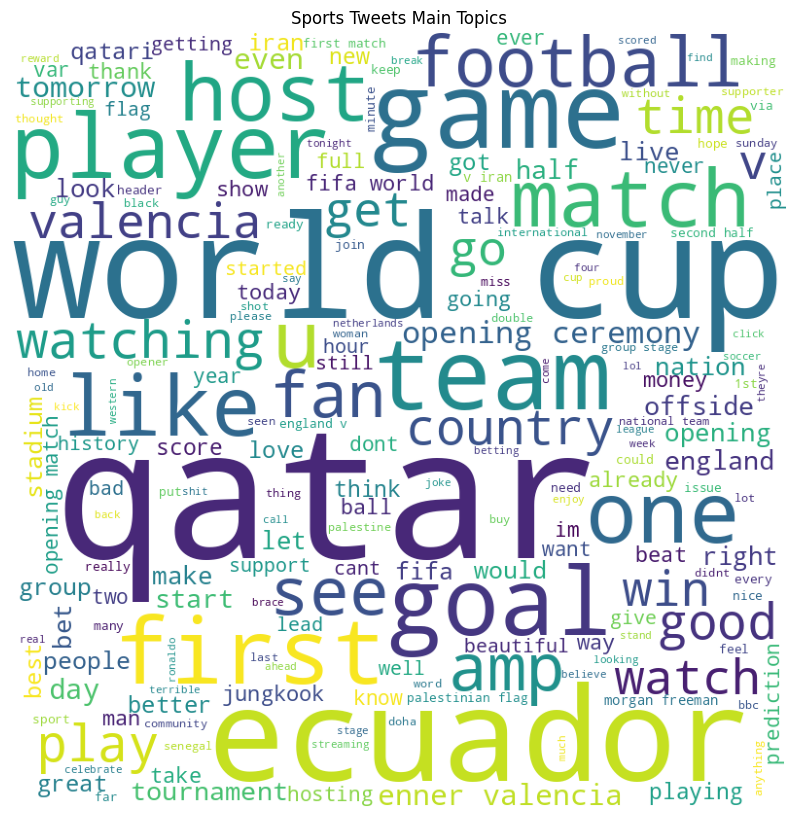

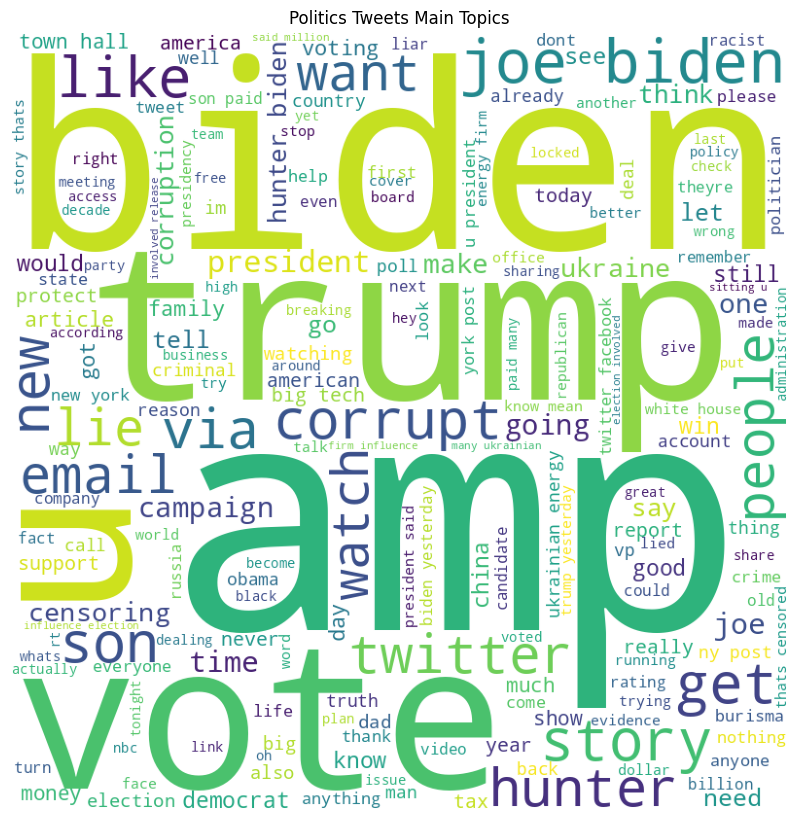

In [41]:
def generate_word_cloud(tweets, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = stop_words, 
                          min_font_size = 10).generate(' '.join(tweets))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(title)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

generate_word_cloud(sports_tweets['lemmatized_tweet'], "Sports Tweets Main Topics")

generate_word_cloud(politics_tweets['lemmatized_tweet'], "Politics Tweets Main Topics")